In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. We load the optimized dataset (the one with 41 columns)
file_path = '../data/IDS_Optimized_After_Corelation.parquet'
df = pd.read_parquet(file_path)

print(f"Dataset loaded: {df.shape}")

# 2. We separate X (Data) and y (Label)
X = df.drop('Label', axis=1)
y = df['Label']

# 3. Train-Test Split 
# Test_size = 20% (industry standard)
# Stratify = y 
print("The data is divided into Train and Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 4. We check the distribution
print("-" * 30)
print(f"Training Set: {X_train.shape} (Here the model LEARNS)")
print(f"Testing Set:  {X_test.shape} (Here the model takes the EXAM)")
print("-" * 30)

# We check the FULL distribution in the training set
print("Class distribution in y_train (All labels):")
print("-" * 40)
print(y_train.value_counts())

print("\nClass distribution in y_test (Heartbleed Check):")
print("-" * 40)
print(y_test.value_counts())

Dataset încărcat: (584991, 41)
Se împart datele în Train și Test...
------------------------------
Training Set: (467992, 40) (Aici modelul ÎNVAȚĂ)
Testing Set:  (116999, 40) (Aici modelul dă EXAMENUL)
------------------------------
Distribuția claselor în y_train (Toate etichetele):
----------------------------------------
Label
0    312987
2    138277
1      8229
4      4308
3      4182
5         9
Name: count, dtype: int64

Distribuția claselor în y_test (Verificare Heartbleed):
----------------------------------------
Label
0    78248
2    34569
1     2057
4     1077
3     1046
5        2
Name: count, dtype: int64


In [3]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 1. Definim Pipeline-ul
# Ordinea este critică: Scalare -> Resampling (SMOTE) -> Model
pipeline = Pipeline([
    ('scaler', RobustScaler()),        # Pasul 1: Aducem datele la aceeași scară (ignora outliers)
    ('smote', SMOTE(random_state=42)), # Pasul 2: Generăm date sintetice pentru Heartbleed
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)) # Pasul 3: Modelul
])

print("✅ Pipeline construit cu succes!")

# 2. Definim strategia de Cross-Validation (Validare Încrucișată)
# StratifiedKFold asigură că în fiecare "felie" de validare avem proporția corectă de atacuri
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("✅ Strategia de validare definită: 5-Fold Stratified Cross-Validation")

# 3. (Opțional - Test Rapid) Verificăm dacă totul merge printr-o validare rapidă
# ATENȚIE: Poate dura 1-2 minute, deoarece antrenează modelul de 5 ori!
print("\n🚀 Începe validarea încrucișată (Testăm performanța pe 5 scenarii diferite)...")

# Folosim F1-Macro ca metrică principală pentru că ne pasă de clasele mici (Heartbleed)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring='f1_macro', n_jobs=-1)

print(f"\nRezultate Cross-Validation (F1-Macro): {scores}")
print(f"Media Performanței: {scores.mean():.4f} (+/- {scores.std():.4f})")

✅ Pipeline construit cu succes!
✅ Strategia de validare definită: 5-Fold Stratified Cross-Validation

🚀 Începe validarea încrucișată (Testăm performanța pe 5 scenarii diferite)...

Rezultate Cross-Validation (F1-Macro): [0.99448277 0.99532498 0.8296395  0.99475798 0.99521119]
Media Performanței: 0.9619 (+/- 0.0661)


⏳ Se antrenează modelul final (poate dura puțin)...
✅ Model antrenat!

📝 CLASSIFICATION REPORT (Performanța pe Test):
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78248
           1       0.99      1.00      1.00      2057
           2       1.00      1.00      1.00     34569
           3       0.98      1.00      0.99      1046
           4       0.99      0.99      0.99      1077
           5       1.00      1.00      1.00         2

    accuracy                           1.00    116999
   macro avg       0.99      1.00      1.00    116999
weighted avg       1.00      1.00      1.00    116999



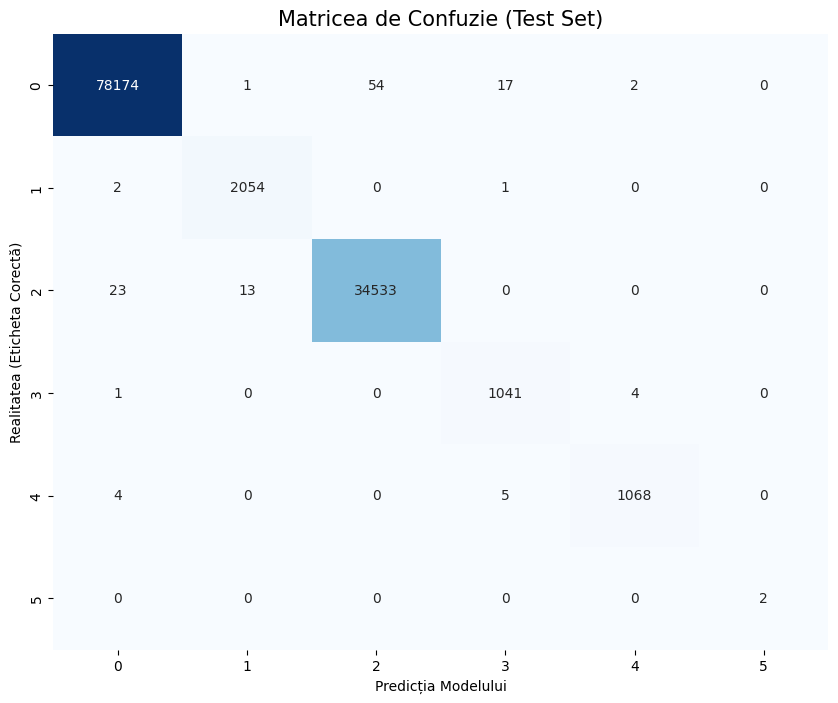

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Antrenăm Pipeline-ul pe TOATE datele de antrenament
print("⏳ Se antrenează modelul final (poate dura puțin)...")
pipeline.fit(X_train, y_train)
print("✅ Model antrenat!")

# 2. Facem predicții pe setul de TEST (Examenul)
y_pred = pipeline.predict(X_test)

# 3. Raportul Detaliat de Clasificare
print("\n📝 CLASSIFICATION REPORT (Performanța pe Test):")
print("-" * 60)
# Aici vom vedea precizia pentru fiecare atac în parte
print(classification_report(y_test, y_pred))

# 4. Matricea de Confuzie Vizuală
# Ne arată exact unde face confuzii modelul
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matricea de Confuzie (Test Set)', fontsize=15)
plt.xlabel('Predicția Modelului')
plt.ylabel('Realitatea (Eticheta Corectă)')
plt.show()